Vitals Correlations

In [5]:
# Import Modules

import sys
sys.path.append("..") #give this script access to all modules in parent directory
import os
from pathlib import Path
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

# Import Statistical Tests and tsfel
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import tsfel
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statistics

# Import Previous Scripts
import Filtering
import Correlations


Correlation Function using TSFEL

In [6]:
def pearson_corr_vitals_sbs(signal, sbs, signal_name, lead_time, slice_size_min):
    '''
    @param signal: vitals signal input
    @param sbs: sbs corresponding to vitals signal
    @param signal_name: name of input signal
    '''
    # Assuming tsfel and other necessary imports are already done

    cfg_file = tsfel.get_features_by_domain()
    features_list = []
    sbs_list = []
    fs = .5
    
    # Assuming signal and sbs are lists
    for i in range(len(signal)):
        sbs_list.append(sbs[i])
        features = tsfel.time_series_features_extractor(cfg_file, signal[i], fs, verbose=0)
        features_list.append(features)

    # print(features_list)
    columns = [col for col in list(features_list[0])]
    features_array = np.array(features_list).reshape(-1, 359)
    # print(features_array)
    df_features = pd.DataFrame(features_array)
    
    #Pearson Correlation Coefficient
    my_dict = {}
    df_features.columns = columns
    for i in columns:
        y = sbs_list
        x = list(df_features[i])
        if len(y) >= 2 and len(x) >= 2:
            corr, _ = pearsonr(y, x)
            my_dict[i] = np.abs(corr)
        else:
            my_dict[i] = np.nan

    # Filter out NaN values from the dictionary
    clean_dict = {k: v for k, v in my_dict.items() if not np.isnan(v)}

    # Retrieve N features with best correlation coefficient  
    # Initialize N
    N = 5
    
    # N largest values in dictionary
    # Using sorted() + itemgetter() + items()
    res = dict(sorted(clean_dict.items(), key=itemgetter(1), reverse=True)[:N])

    # Plotting
    y = list(res.keys())
    x = list(res.values())
    
    # Figure Size
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Horizontal Bar Plot
    ax.barh(y, x)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad=5)
    ax.yaxis.set_tick_params(pad=10)
    
    # Add x, y gridlines
    ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
    
    # Show top values 
    ax.invert_yaxis()
    
    # Set x axis range
    ax.set_xlim([0.8 * min(x), 1.1 * max(x)])
    
    # Add Plot Title
    ax.set_title(f'Correlation between top features and SBS for\n {signal_name}_{lead_time}MIN_{slice_size_min - lead_time}MIN)',
                            loc ='left', )
    
    # Show Plot
    plt.show()
    
    # Return the top N correlated features
    return "The top N value pairs are " + str(res)

In [7]:
# Set Parameters
data_dir = 'C:/Users/sidha/OneDrive/Sid Stuff/PROJECTS/iMEDS Design Team/Data Analysis/PedAccel/data_analysis/PythonPipeline/PatientData'
# data_dir = r'C:\Users\jakes\Documents\DT 6 Analysis\PythonCode\PedAccel\data_analysis\PythonPipeline\PatientData'
slice_size_min = 15
lead_time = 10
sr = .5

ProcessingPatient2
original hr vitals array shape: (111, 450) 
hr SBS index 0 has insufficient data, zeros appended in place
hr SBS index 21 has insufficient data, zeros appended in place
hr SBS index 44 has insufficient data, zeros appended in place
hr SBS index 65 has insufficient data, zeros appended in place
hr SBS index 97 has insufficient data, zeros appended in place
hr SBS index 98 has insufficient data, zeros appended in place
hr SBS index 99 has insufficient data, zeros appended in place
hr SBS index 100 has insufficient data, zeros appended in place
hr SBS index 101 has insufficient data, zeros appended in place
hr SBS index 102 has insufficient data, zeros appended in place
hr SBS index 103 has insufficient data, zeros appended in place
hr SBS index 104 has insufficient data, zeros appended in place
hr SBS index 105 has insufficient data, zeros appended in place
hr SBS index 106 has insufficient data, zeros appended in place
hr SBS index 107 has insufficient data, zeros app

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


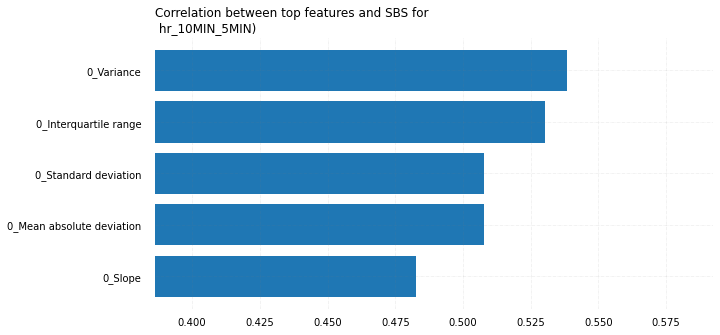

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


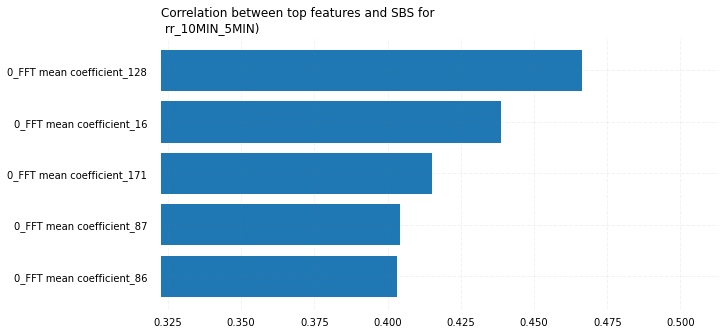

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


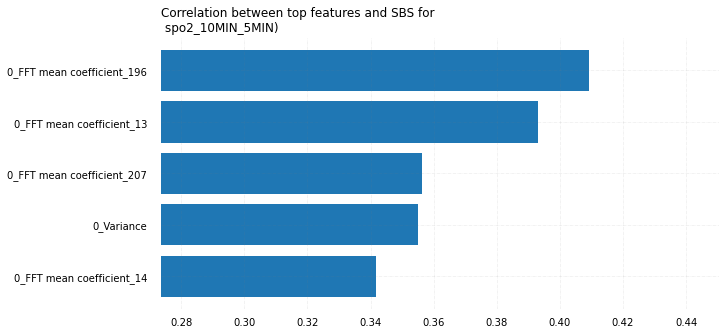

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


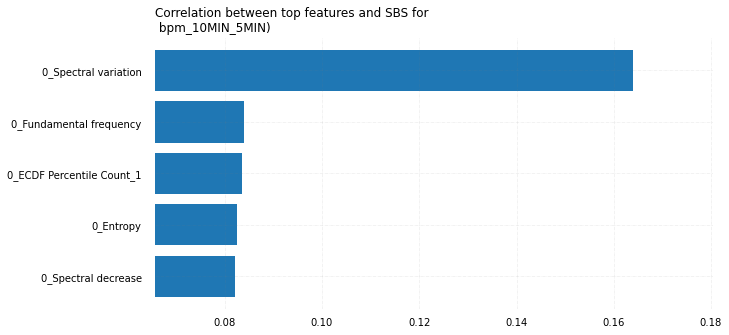

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


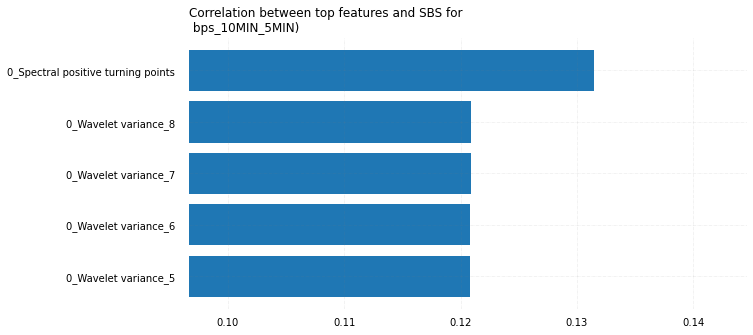

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


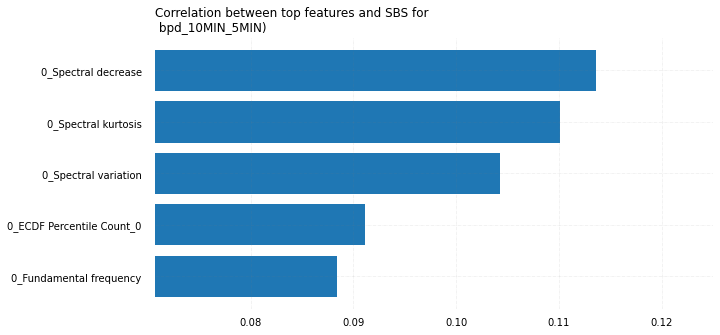

ProcessingPatient3
original hr vitals array shape: (58, 450) 
hr SBS index 0 has insufficient data, zeros appended in place
hr SBS index 11 has insufficient data, zeros appended in place
hr SBS index 39 has insufficient data, zeros appended in place
hr SBS index 40 has insufficient data, zeros appended in place
final hr vitals array shape: (58, 450)
original rr vitals array shape: (58, 450) 
rr SBS index 0 has insufficient data, zeros appended in place
rr SBS index 1 has insufficient data, zeros appended in place
rr SBS index 2 has insufficient data, zeros appended in place
rr SBS index 3 has insufficient data, zeros appended in place
rr SBS index 4 has insufficient data, zeros appended in place
rr SBS index 5 has insufficient data, zeros appended in place
rr SBS index 6 has insufficient data, zeros appended in place
rr SBS index 7 has insufficient data, zeros appended in place
rr SBS index 8 has insufficient data, zeros appended in place
rr SBS index 9 has insufficient data, zeros app

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


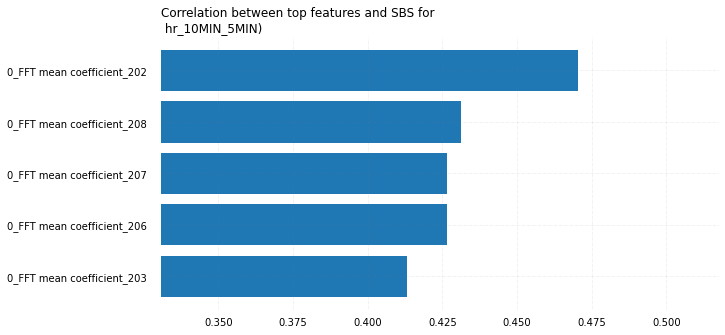

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


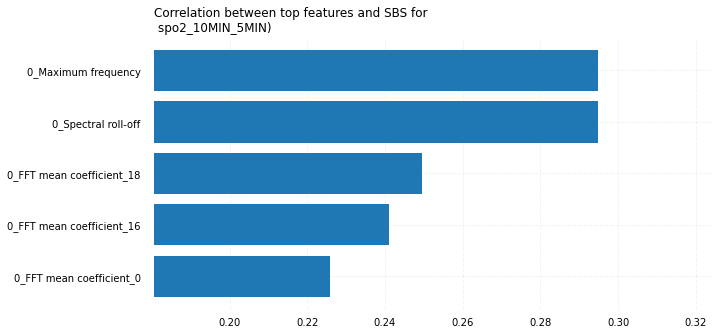

In [8]:
#There is no error handling in place, the .mat file must exist
for patient in os.listdir(data_dir):
    # filter out non-directories
    print(f"Processing{patient}")
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
       # data_filepath_accel = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN.mat')           
        data_filepath_vitals = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_Validated_Stim.mat')
        
       # accel_data = loadmat(data_filepath_accel)
       # x_mag = accel_data["x_mag"]
       # accel_SBS = accel_data["sbs"].flatten()
        
        vitals_data = loadmat(data_filepath_vitals)
        temp_hr = vitals_data['heart_rate']
        temp_SpO2 = vitals_data['SpO2']
        temp_rr = vitals_data['respiratory_rate']
        temp_bps = vitals_data['blood_pressure_systolic']
        temp_bpm = vitals_data['blood_pressure_mean']
        temp_bpd = vitals_data['blood_pressure_diastolic']
        vitals_SBS = vitals_data['sbs'].flatten()
        hr = []
        rr = []
        SpO2 = []
        bpm = []
        bps = []
        bpd = []
        vitals_list = [hr,rr,SpO2,bpm,bps,bpd]
        vitals_names = ['hr','rr','spo2','bpm','bps','bpd']
        temp_vitals = [temp_hr,temp_rr, temp_SpO2,temp_bpm,temp_bps,temp_bpd] 
        
        flag_list = [0] * (int)(sr * 60 * slice_size_min) #generate a list to insert in place of invalid data, 
        #this list serves as a flag for a window to ignore in the box plot function
        
        
        for j in range(len(vitals_list)): #go through every vitals metric
            print(f'original {vitals_names[j]} vitals array shape: {np.array(temp_vitals[j]).shape} ')
            for i in range(len(vitals_SBS)): #go through every SBS score for each vitals metric
                if (Filtering.checkVitals(temp_vitals[j][i], slice_size_min, vitals_names[j])): #check the data in a single window
                    vitals_list[j].append(temp_vitals[j][i]) #append that single window data to the 2D hr,rr,spo2,bpm,bps,bpd arrays if that window's data is valid
                else:
                    vitals_list[j].append(flag_list) #append an array of zeros for window number i for the jth vitals metric if the data is invalid(i.e. too many NaN points)
                    print(f'{vitals_names[j]} SBS index {i} has insufficient data, zeros appended in place') 
            print(f'final {vitals_names[j]} vitals array shape: {np.array(vitals_list[j]).shape}') #should be the number of SBS scores by the number of samples in a window
        
        
        
        for signal, name in zip(vitals_list, vitals_names):
            mean_val = np.mean(signal)
            if len(signal) != 0:
                if mean_val != 0:
                    pearson_corr_vitals_sbs(signal, vitals_SBS, name, lead_time, slice_size_min)